# Task 2: Necessary and Sufficient Explanations

In [ ]:
# produce one ground truth per bug report
# choose metrics for readability and semantic similarity
# define thresholds
# find the best scoring explanation
# start merging worse explanations together

## Generate Ground Truth Data per Bug Report

In [1]:
# Load bug reports explanations

import os
from pathlib import Path
import pandas as pd
import json

data = pd.read_csv("../../data/answerList_data.csv")

bug_reports_data = {}

# read one file per failing method
for failing_method in data['FailingMethod'].unique():
    with open(Path(f"../exercise2/{failing_method}.txt"), 'r') as f:
        # individual explanations are separated by a newline
        explanations = f.read().split("\n")
        explanations = [explanation for explanation in explanations if explanation != ""]
        bug_reports_data[failing_method] = explanations   

print(bug_reports_data["HIT01_8"])   


['Minutes are set to -15; which is less then 0 and it throws illegal arg exception', 'The code never gets that far. The problem is at line 279 which prevents a negative minutes value being accepted even though the programmer comments indicate that since version 2.3 negative minutes up to -59 are acceptable. The @throws IllegalArgumentException comment is also referring to versions before 2.3.', 'In the code there is a check that 0 <= minutes < 60 and the minutesOffset is -15 which does not fall into these prarmeters thus throwing an Exception', 'There is a logical check for if minuteOffset is less than 0 or greater than 59 causing it to throw an exception because the value is out of bounds (negative number)', 'YES. The issue is on line 279 (as I explained in my first question; of which I misunderstood that I was only being asked about the specific issue; not generalized issue). On line 279 the variable "minutesOffSet" is parameterized to throw an exception if it is < 0 or > 59. Line 27

In [2]:
#using bart

from transformers import pipeline
import json

summarizer = pipeline("summarization")

ground_truth_explanations = {}

def generate_ground_truth(method, explanations):
    combined_text = " ".join(explanations)

    max_input_length = 1024
    combined_text = combined_text[:max_input_length]

    summary = summarizer(
        combined_text, max_length=100, min_length=30, do_sample=False, truncation=True
    )
    return summary[0]["summary_text"]

for method, reports in bug_reports_data.items():
    explanation = generate_ground_truth(method, reports)
    ground_truth_explanations[method] = explanation

# Save to file
with open("ground_truth_explanations_bart.json", "w") as f:
    json.dump(ground_truth_explanations, f, indent=4)

print("Ground truth explanations saved")

c:\Users\bzwad\anaconda3\envs\DSWebscrape\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [2]:
with open("ground_truth_explanations_bart.json", "r") as f:
    ground_truth_explanations = json.load(f)

print(ground_truth_explanations["HIT01_8"])

 Minutes are set to -15; which is less then 0 and it throws illegal arg exception . The code never gets that far . The problem is at line 279 which prevents a negative minutes value being accepted . The programmer comments indicate that since version 2.3 negative minutes up to -59 are acceptable .


The [Bart](https://huggingface.co/docs/transformers/model_doc/bart#transformers.BartForConditionalGeneration) model is a model from the nlp domain and can be used for summarization tasks.
While the explanations generated by Bart contain useful information, they are often repetitive and not concise. In this task, we aim to generate necessary and sufficient explanations for each bug report, so we decided to try another model.

### Llama
Llama 3.2 3B is a 3-billion-parameter multilingual large language model, optimized for advanced natural language processing tasks like dialogue generation, reasoning, and summarization. It should therefore be perfect for our task. Furthermore, it is also more recent than Bart.

In [3]:
#load api key
from dotenv import load_dotenv

load_dotenv()

openai_api_key = os.environ.get('OPENAI_API_KEY')

In [17]:
from openai import OpenAI
import json

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=openai_api_key,
)

# Function to generate summaries using LLaMA 3.2
def generate_ground_truth(method, explanations):
    combined_text = " ".join(explanations)

    # Truncate input to fit within token limits
    max_input_length = 4000
    combined_text = combined_text[:max_input_length]

    # OpenRouter API call
    completion = client.chat.completions.create(
        model="meta-llama/llama-3.2-1b-instruct:free",
        messages=[
            {
                "role": "system",
                "content": "You are an expert summarizer. Given detailed bug reports, provide a single, comprehensive explanation that includes all necessary and sufficient information to understand and fix the bug.",
            },
            {
                "role": "user",
                "content": f"Summarize the following bug reports:\n\n{combined_text}",
            },
        ],
        max_tokens=200  # Adjust to control summary length
    )

    return completion.choices[0].message.content

# Generate summaries for each method
ground_truth_explanations = {}

for method, reports in bug_reports_data.items():
    explanation = generate_ground_truth(method, reports)
    ground_truth_explanations[method] = explanation

# Save to JSON file
with open("ground_truth_explanations_llama.json", "w") as f:
    json.dump(ground_truth_explanations, f, indent=4)

print("Ground truth explanations saved using LLaMA 3.2")

Ground truth explanations saved using LLaMA 3.2


In [4]:
# manually inspect the generated ground truth explanations
with open("ground_truth_explanations_llama.json", "r") as f:
    ground_truth_explanations = json.load(f)

print(ground_truth_explanations["HIT01_8"])

**Bug Summary**

The provided bug report describes a situation where the `MinutesOutOfRangeException` is thrown when the `minutesOffset` parameter is less than -59, despite the comments indicating that negative minutes up to -59 are acceptable in version 2.3. The issue lies in the way the `minutesOffset` variable is checked and parameterized in the method.

**Detailed Explanation**

The bug is caused by the incorrect parameterization of the `minutesOffset` variable in the method. The line `if (minutesOffset < -59 || minutesOffset > 59)` is incorrect because it checks for the range of -59 to 59, but the `minutesOffset` variable is actually an offset in minutes from UTC, which is a signed value. The correct parameterization should be `if (minutesOffset < -59 || minutesOffset > 59)`.

The issue is further complicated by the fact that the `minutesOffset` variable is set to -15 through the `DateTime


As we can see the generated explanations are of high quality and are more concise than the ones generated by Bart. Since we don't need the detailed explanations, we can discard them and only keep the short summary.

In [4]:
# As we can see the generated explanations are of high quality and are more concise than the ones generated by Bart. Since we don't need the detailed explanations, we can discard them and only keep the short summary.

for method, explanation in ground_truth_explanations.items():
    # remove beginning "**Bug Summary**\n\n"
    ground_truth_explanations[method] = explanation.split("\n\n")[1]
    print(ground_truth_explanations[method])

    # split explanation after **Bug Summary** and before **Detailed Explanation**
    if "**Detailed Explanation**" in ground_truth_explanations[method]:
        ground_truth_explanations[method] = ground_truth_explanations[method].split("**Detailed Explanation**")[0]

# Save to JSON file
with open("ground_truth_explanations.json", "w") as f:
    json.dump(ground_truth_explanations, f, indent=4)

The provided bug report describes a situation where the `MinutesOutOfRangeException` is thrown when the `minutesOffset` parameter is less than -59, despite the comments indicating that negative minutes up to -59 are acceptable in version 2.3. The issue lies in the way the `minutesOffset` variable is checked and parameterized in the method.
The provided bug report describes a Java method `getPaint` within the `Color` class that throws an `IllegalArgumentException` when an invalid color value is passed. The issue lies in the way the color value is calculated and used within the method.
The issue lies in the fact that the `pos` variable is initialized to 0, which means it starts at the beginning of the string. However, when the function `escapeCsv()` is called, it uses the `pos` variable to access the characters in the string. The problem is that the `pos` variable is incremented at a rate faster than the characters are consumed, causing it to become longer than the string length.
The pro

## Define Metrics & Thresholds

In [5]:
# load the ground truth explanations
with open("ground_truth_explanations.json", "r") as f:
    ground_truth_explanations = json.load(f)

### Readability

We will use the [Flesch Reading Ease](https://simple.wikipedia.org/wiki/Flesch_Reading_Ease) score to measure the readability of the explanation. The Flesch Reading Ease score is a measure of how easy a text is to read. The higher the score, the easier the text is to read. It is based on the idea that shorter words and shorter sentences are easier to read. The maximum score is 121.22. There is no lower limit, negative values are valid.

In [89]:
import textstat

# calculate readability scores for the ground truth explanations
readability_scores = {}
for method, explanation in ground_truth_explanations.items():
    readability_scores[method] = textstat.flesch_reading_ease(explanation)

# sort the explanations by readability
sorted_explanations = sorted(readability_scores.items(), key=lambda x: x[1], reverse=True)

# print readibility scores
for method, score in sorted_explanations:
    print(f"{method}: {score}")

HIT03_6: 64.75
HIT05_35: 58.62
HIT07_33: 53.04
HIT02_24: 51.18
HIT04_7: 50.16
HIT08_54: 46.81
HIT06_51: 43.02
HIT01_8: 28.67


Most ground truth explanations have a Flesch Reading Ease score between 40 and 70, and are therefore of average readability. Given that the explanation of coding errors is often complex, this range is acceptable. 
Since there are some deviations between the different explanations, we determine the threshold relatively per bug report. We set the threshold to 80% of the Flesch Reading Ease score of the ground truth explanation. We hypothesize that this threshold will be sufficient to filter out explanations of low quality and readability. Since the average readability score per bug report is slightly higher, this allows for some tolerance for changes in the readability caused by the model.


In [90]:
# look at average readability score of explanations per failing method

average_readability_scores = {}
for method, explanations in bug_reports_data.items():
    scores = [textstat.flesch_reading_ease(explanation) for explanation in explanations]
    average_readability_scores[method] = sum(scores) / len(scores)

for method, score in average_readability_scores.items():
    print(f"{method}: {score}")

HIT01_8: 66.29499999999999
HIT02_24: 66.48525000000001
HIT03_6: 78.65999999999997
HIT04_7: 70.03829999999998
HIT05_35: 74.99766666666666
HIT06_51: 74.76399999999997
HIT07_33: 71.59666666666664
HIT08_54: 75.70616666666666


In [91]:
readability_threshold = {}
for method, score in readability_scores.items():
    readability_threshold[method] = round(score * 0.8,3)

for method, score in readability_threshold.items():
    print(f"{method}: {score}")

HIT01_8: 22.936
HIT02_24: 40.944
HIT03_6: 51.8
HIT04_7: 40.128
HIT05_35: 46.896
HIT06_51: 34.416
HIT07_33: 42.432
HIT08_54: 37.448


### Semantic Similarity

We will use Sentence Transformers to calculate the semantic similarity between the explanation and the bug report. Sentence Transformers is a Python library that allows us to use pre-trained models to calculate sentence embeddings. We hope that this will be more accurate than simple embeddings like Word2Vec or TF-IDF.

In [92]:
# expects user explanations as dict
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load a high-performance model for semantic similarity
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

def compute_similarity(ground_truth, user_explanation):
    """
    Computes cosine similarity between the ground truth explanation and a user-given explanation.
    """
    embeddings = model.encode([ground_truth, user_explanation], convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return similarity.item()

In [93]:
# Compute similarity for all user explanations
similarity_scores = {}

for method, ground_truth in ground_truth_explanations.items():
    scores = [compute_similarity(ground_truth, user_exp) for user_exp in bug_reports_data.get(method, [])]
    similarity_scores[method] = scores

# average similarity per failing method
average_similarity_scores = {}
for method, scores in similarity_scores.items():
    average_similarity_scores[method] = sum(scores) / len(scores)

for method, score in average_similarity_scores.items():
    print(f"{method}: {score}")

HIT01_8: 0.5436896428233012
HIT02_24: 0.3701791672501713
HIT03_6: 0.25586818529409355
HIT04_7: 0.2914702493418008
HIT05_35: 0.42632644800469277
HIT06_51: 0.30135327534129225
HIT07_33: 0.4918408831271032
HIT08_54: 0.3938455417131384


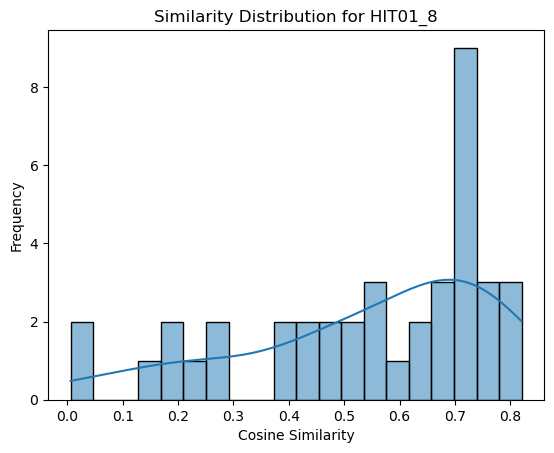

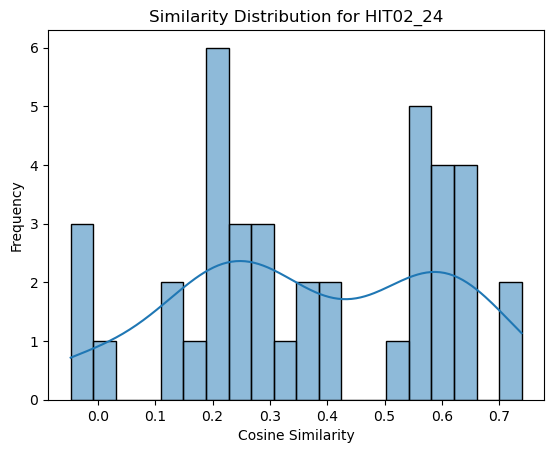

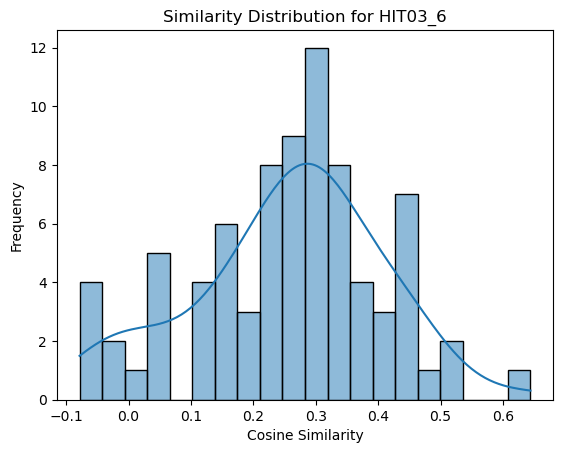

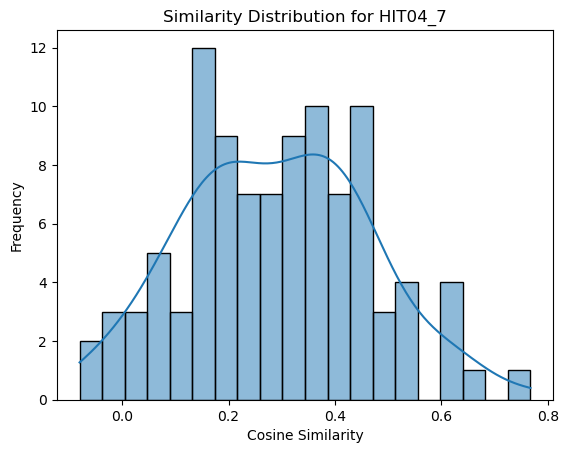

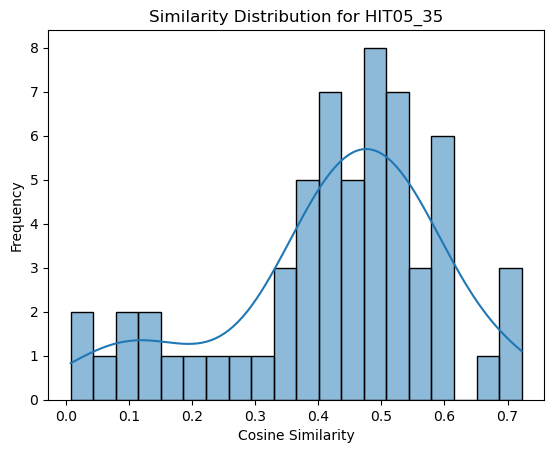

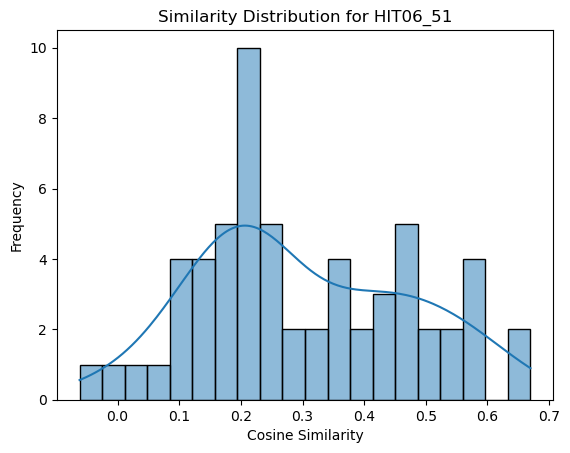

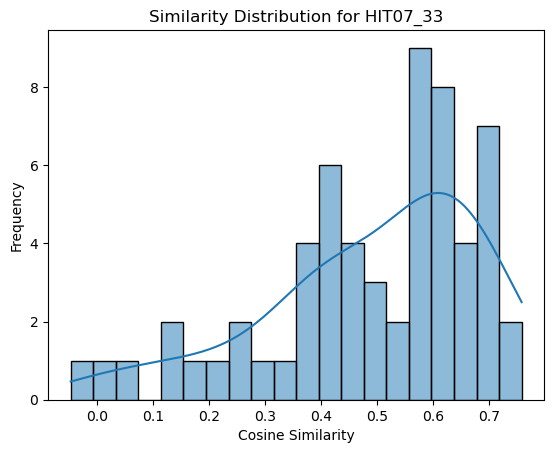

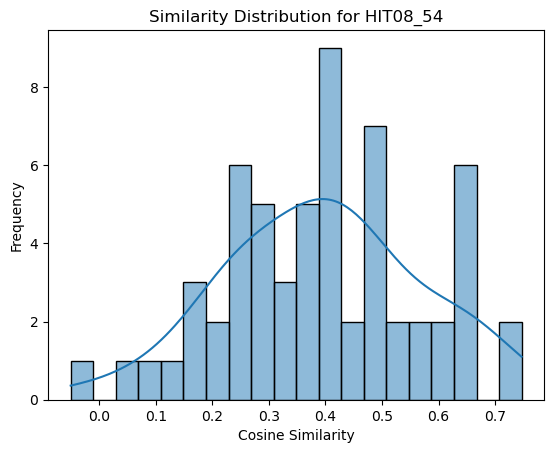

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_distribution_for_report(method, scores):
    sns.histplot(scores, bins=20, kde=True)
    plt.title(f"Similarity Distribution for {method}")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.show()

for method, scores in similarity_scores.items():
    plot_similarity_distribution_for_report(method, similarity_scores[method])

Looking at the average cosine similarity between the explanations and the bug reports, we can see that the cosine similarity is around 0.3-0.5. Because the average similarity per bug report still allows for a lot of difference, we decided to go with the 70th percentile of the cosine similarity as the threshold. We expect this threshold to be more challenging to reach and more interesting for the task.

In [94]:
# set similarity threshold to 70th percentile
similarity_threshold = {}
for method, scores in similarity_scores.items():
    similarity_threshold[method] = np.percentile(scores, 70)

for method, score in similarity_threshold.items():
    print(f"{method}: {score}")

HIT01_8: 0.7063461601734161
HIT02_24: 0.5649046778678893
HIT03_6: 0.32944928407669066
HIT04_7: 0.38390407562255857
HIT05_35: 0.5162835419178009
HIT06_51: 0.4160767793655395
HIT07_33: 0.6244548857212067
HIT08_54: 0.4770480155944824


## Find Minimal Number of Explanations

In [95]:
# for all methods find highest readability score and check the similarity score
most_readable_explanations = {}
for method, explanations in bug_reports_data.items():
    readability_scores = [textstat.flesch_reading_ease(explanation) for explanation in explanations]
    max_readability_index = readability_scores.index(max(readability_scores))
    most_readable_explanations[method] = explanations[max_readability_index]

# check similarity score
most_readable_similarity_scores = {}
for method, explanation in most_readable_explanations.items():
    most_readable_similarity_scores[method] = compute_similarity(ground_truth_explanations[method], explanation)

for method, score in most_readable_similarity_scores.items():
    print(f"{method}: {score}")

HIT01_8: 0.018344800919294357
HIT02_24: -0.047606274485588074
HIT03_6: 0.031428221613168716
HIT04_7: 0.08298180997371674
HIT05_35: 0.5033749938011169
HIT06_51: 0.10949976742267609
HIT07_33: 0.04427710548043251
HIT08_54: -0.05031628906726837


In [96]:
# get deviation from threshold in percent
deviation_from_threshold = {}
for method, score in most_readable_similarity_scores.items():
    deviation_from_threshold[method] = round((score - similarity_threshold[method]) / similarity_threshold[method] * 100, 2)

for method, deviation in deviation_from_threshold.items():
    print(f"{method}: {deviation}%")

HIT01_8: -97.4%
HIT02_24: -108.43%
HIT03_6: -90.46%
HIT04_7: -78.38%
HIT05_35: -2.5%
HIT06_51: -73.68%
HIT07_33: -92.91%
HIT08_54: -110.55%


In [97]:
# for all methods find highest similarity score and check the readability score
most_similar_explanations = {}
for method, explanations in bug_reports_data.items():
    similarity_scores = [compute_similarity(ground_truth_explanations[method], explanation) for explanation in explanations]
    max_similarity_index = similarity_scores.index(max(similarity_scores))
    most_similar_explanations[method] = explanations[max_similarity_index]

# check readability score
most_similar_readability_scores = {}
for method, explanation in most_similar_explanations.items():
    most_similar_readability_scores[method] = textstat.flesch_reading_ease(explanation)

for method, score in most_similar_readability_scores.items():
    print(f"{method}: {score}")


HIT01_8: 37.3
HIT02_24: 43.06
HIT03_6: 76.42
HIT04_7: 71.78
HIT05_35: 69.07
HIT06_51: 65.52
HIT07_33: 77.23
HIT08_54: 64.1


In [98]:
# get deviation from threshold in percent
deviation_from_threshold = {}
for method, score in most_similar_readability_scores.items():
    deviation_from_threshold[method] = round((score - readability_threshold[method]) / readability_threshold[method] * 100, 2)

for method, deviation in deviation_from_threshold.items():
    print(f"{method}: +{deviation}%")

HIT01_8: +62.63%
HIT02_24: +5.17%
HIT03_6: +47.53%
HIT04_7: +78.88%
HIT05_35: +47.28%
HIT06_51: +90.38%
HIT07_33: +82.01%
HIT08_54: +71.17%


Just because a method is highly readable does not mean that it has to be semantically similar to the ground truth explanation. However, if the explanation is highly similar then it is likely to be readable as well. The given explanations even meet the readability threshold already.
We will therefore start with feeding the most similar explanations to the ground truth explanation to the model and then evaluate if we still meet the similarity and readability threshold.

In [40]:
from openai import OpenAI
import json

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="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",
)

# Function to generate summaries using LLaMA 3.2
def generate_summary(method, explanations):
    combined_text = " ".join(explanations)

    # Truncate input to fit within token limits
    max_input_length = 4000
    combined_text = combined_text[:max_input_length]

    # OpenRouter API call
    completion = client.chat.completions.create(
        model="meta-llama/llama-3.2-1b-instruct:free",
        messages=[
            {
                "role": "system",
                "content": "You are an expert summarizer. Given detailed bug reports, provide a single, comprehensive explanation that includes all necessary and sufficient information to understand and fix the bug.",
            },
            {
                "role": "user",
                "content": f"Summarize the following bug reports:\n\n{combined_text}",
            },
        ],
        max_tokens=200  # Adjust to control summary length
    )

    if completion.choices is not None:
        return completion.choices[0].message.content
    else:
        return "-1"


In [ ]:
# Generate summaries for each method
summaries = {}

for method, reports in most_similar_explanations.items():
    explanation = generate_summary(method, reports)
    # remove prefixes
    if "\n\n" in explanation:
        explanation = explanation.split("\n\n")[1]
    summaries[method] = explanation

# Save to JSON file
with open("summaries.json", "w") as f:
    json.dump(summaries, f, indent=4)

print("Summaries saved")

In [71]:
# calcualte deviation from thresholds in percentage
def calculate_deviation_from_thresholds(readability_scores, similarity_scores, readability_threshold, similarity_threshold):
    deviation_from_read = {}
    for method, score in readability_scores.items():
        deviation_from_read[method] = round((score - readability_threshold[method]) / readability_threshold[method] * 100, 2)

    for method, deviation in deviation_from_threshold.items():
        print(f"{method}: {'+' if deviation>0 else ''}{deviation}%")

    deviation_from_sim = {}
    for method, score in similarity_scores.items():
        deviation_from_sim[method] = round((score - similarity_threshold[method]) / similarity_threshold[method] * 100, 2)
    
    for method, deviation in deviation_from_threshold.items():
        print(f"{method}: {'+' if deviation>0 else ''}{deviation}%")

In [73]:
with open("summaries.json", "r") as f:
    summaries = json.load(f)

In [74]:
# check similarity score and readability score for summaries
summary_similarity_scores = {}
for method, summary in summaries.items():
    summary_similarity_scores[method] = compute_similarity(ground_truth_explanations[method], summary)

#for method, score in summary_similarity_scores.items():
#    print(f"{method}: {score}")

summary_readability_scores = {}
for method, summary in summaries.items():
    summary_readability_scores[method] = textstat.flesch_reading_ease(summary)

#for method, score in summary_readability_scores.items():
#    print(f"{method}: {score}")

calculate_deviation_from_thresholds(summary_readability_scores, summary_similarity_scores, readability_threshold, similarity_threshold)

HIT01_8: +62.63%
HIT02_24: +5.17%
HIT03_6: +47.53%
HIT04_7: +78.88%
HIT05_35: +47.28%
HIT06_51: +90.38%
HIT07_33: +82.01%
HIT08_54: +71.17%
HIT01_8: +62.63%
HIT02_24: +5.17%
HIT03_6: +47.53%
HIT04_7: +78.88%
HIT05_35: +47.28%
HIT06_51: +90.38%
HIT07_33: +82.01%
HIT08_54: +71.17%


Except for HIT02_24 we easily achieved the thresholds by a large margin with just one explanation. We expect that with more explanations the readability and similarity will go down as the model tries to cover more aspects of the bug report. We think it might therefore be beneficial to evaluate the model for every 10 explanations, starting with the 10 most similar explanations to the ground truth explanation.

In [20]:
# print amount of bug reports per failing method
for method, explanations in bug_reports_data.items():
    print(f"{method}: {len(explanations)}")

HIT01_8: 40
HIT02_24: 40
HIT03_6: 80
HIT04_7: 100
HIT05_35: 60
HIT06_51: 60
HIT07_33: 60
HIT08_54: 60


In [87]:
with open("evaluation_results.json", "r") as f:
    evaluation_results = json.load(f)

In [85]:
# for each failing method evaluate the model increasing by 10 explanations each time
# starting with the 10 most similar explanations to the ground truth explanation
# save results for plotting

from time import sleep

for method, explanations in bug_reports_data.items():
    print(f"Evaluating {method}")
    
    # Sort explanations by similarity to ground truth
    similarity_scores = [compute_similarity(ground_truth_explanations[method], explanation) for explanation in explanations]
    sorted_explanations = [explanation for _, explanation in sorted(zip(similarity_scores, explanations), key=lambda x: x[0], reverse=True)]

    # Get existing results or initialize empty list
    results = evaluation_results.get(method, [])
    
    for i in range(10, len(sorted_explanations) + 1, 10):
        # Check if this iteration needs to be (re)generated
        # Look for entries with "-1" summary and matching iteration count
        if any(result[0] == i and result[4] != "-1" for result in results):
            continue
        
        # If this iteration doesn't exist or has a "-1" summary, generate it
        combined_text = " ".join(sorted_explanations[:i])
        truncated = len(combined_text) > 4000  # Check if truncation is needed
        
        summary = generate_summary(method, sorted_explanations[:i])
        summary = summary.split("\n\n")[1] if "\n\n" in summary else summary

        if summary != "-1":
            summary_similarity = compute_similarity(ground_truth_explanations[method], summary)
            summary_readability = textstat.flesch_reading_ease(summary)
        else:
            summary_similarity = 0
            summary_readability = 0

        # Find and replace or append the result
        existing_result_index = next((index for index, result in enumerate(results) if result[0] == i), None)
        
        if existing_result_index is not None:
            results[existing_result_index] = (i, summary_similarity, summary_readability, truncated, summary)
        else:
            results.append((i, summary_similarity, summary_readability, truncated, summary))

    evaluation_results[method] = results
    sleep(5)  # Sleep to avoid rate limiting

Evaluating HIT01_8
Evaluating HIT02_24
Evaluating HIT03_6
Evaluating HIT04_7
Evaluating HIT05_35
Evaluating HIT06_51
Evaluating HIT07_33
Evaluating HIT08_54


In [86]:
# Save to JSON file
with open("evaluation_results.json", "w") as f:
    json.dump(evaluation_results, f, indent=4)

Unfortunately, due to the limited amount of allowed input characters, adding more explanations quickly does not change the results as the input just gets cut off. However, some general trends can be observed. The results are very dependent on the bug report and the explanations. For some bug reports, the model is able to generate a good explanation with just one input, while for others it gets better with more inputs. The similarity score is often a lot higher than the threshold but in some cases it decreases a lot after more examples. This could be because compared to our original ground truth inputs, we rely on different explanations during this evaluation. While they are readable, they might not be as similar to the ground truth explanation.
The readability score is overall closer to our defined threshold and only lies below it for 2 bug reports with few explanations. This is likely due to the fact that the model is able to generate a good explanation with just a few inputs, but the explanation may be relying on specific difficult wording from those explanations.

In [76]:
# for each failing method plot the evaluation results
# show both similarity and readability scores
# also mark the threshold values

import matplotlib.pyplot as plt

def plot_evaluation_results(method, results):
    num_explanations = [result[0] for result in results]
    similarity_scores = [result[1] for result in results]
    readability_scores = [result[2] for result in results]

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Number of Explanations')
    ax1.set_ylabel('Similarity Score', color=color)
    ax1.plot(num_explanations, similarity_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Readability Score', color=color)
    ax2.plot(num_explanations, readability_scores, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.axhline(y=similarity_threshold[method], color='r', linestyle='--', label='Similarity Threshold')
    plt.axhline(y=readability_threshold[method], color='b', linestyle='--', label='Readability Threshold')

    plt.title(f"Evaluation Results for {method}")
    plt.show()

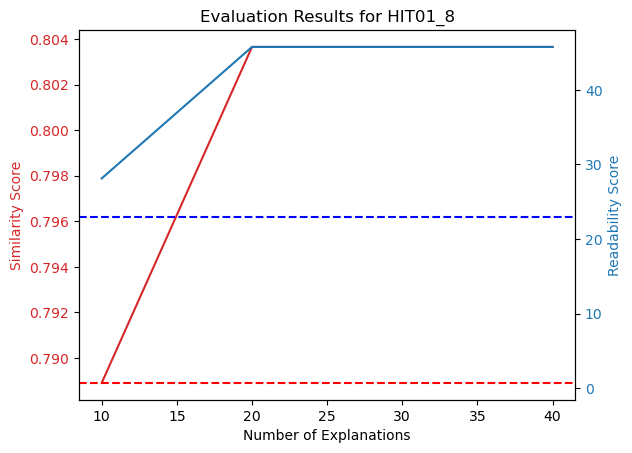

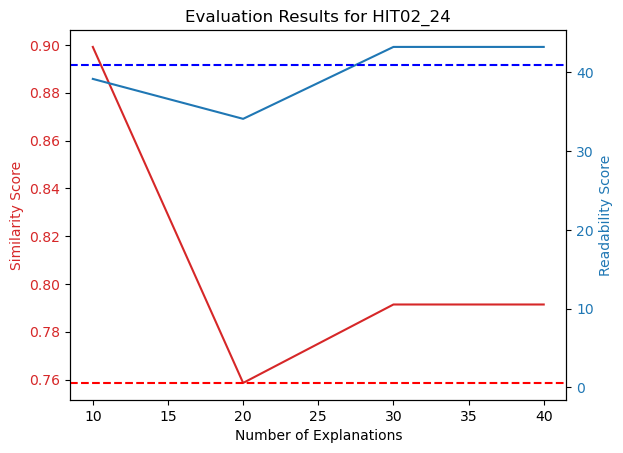

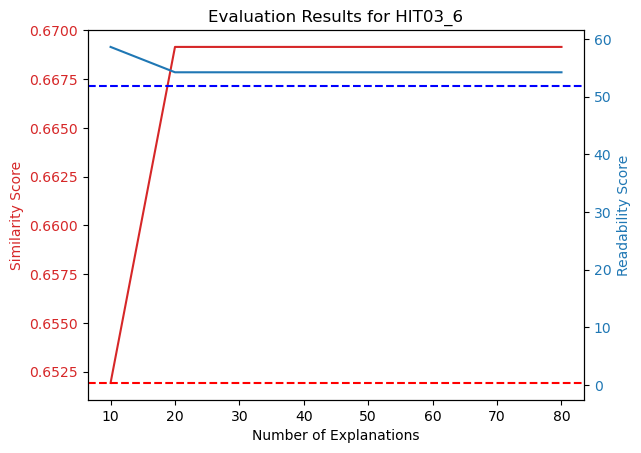

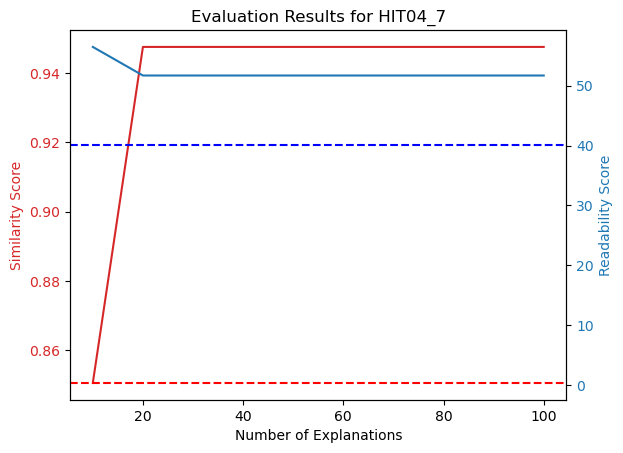

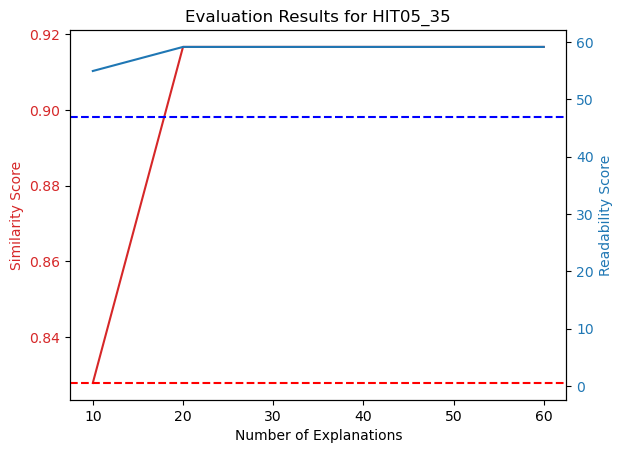

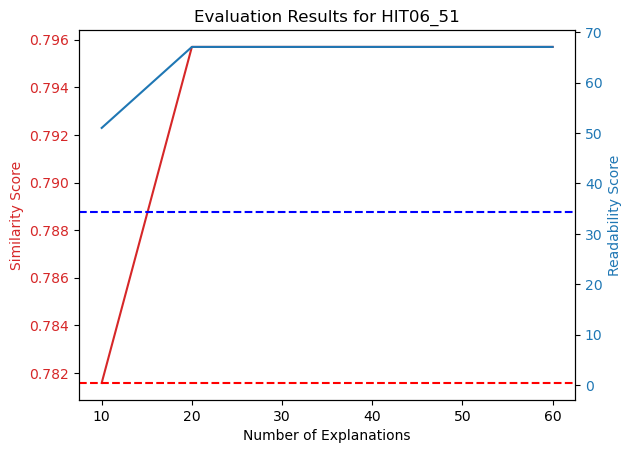

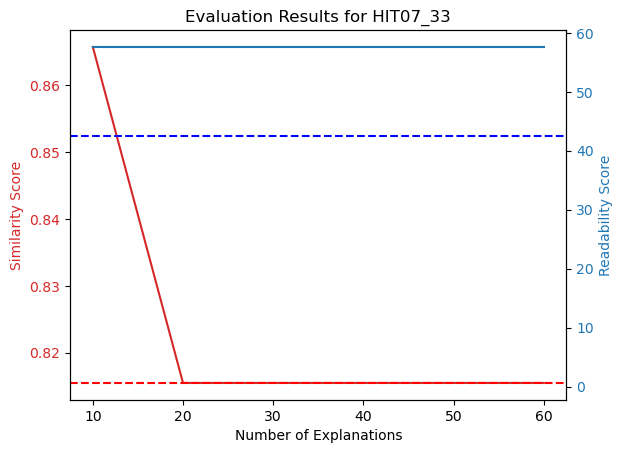

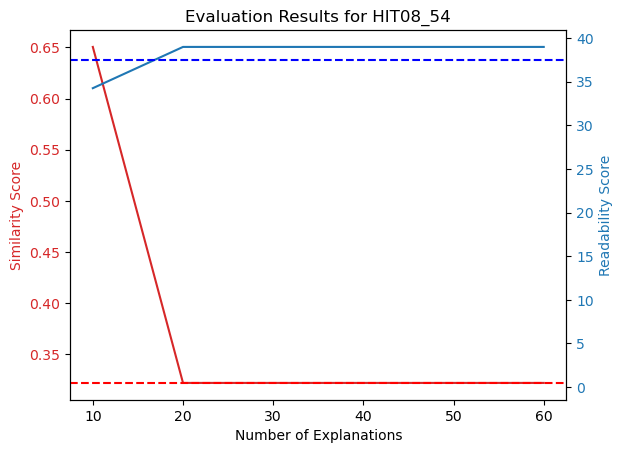

In [88]:
for method, results in evaluation_results.items():
    plot_evaluation_results(method, results)

# uncollapse to see plots

To get a more detailed impression, we now want to look at the top 10 similar explanations for each bug report and evaluate them.

In [99]:
with open("evaluation_results_small.json", "r") as f:
    evaluation_results_small = json.load(f)

In [46]:
# for each failing method evaluate the model increasing by 10 explanations each time
# starting with the 10 most similar explanations to the ground truth explanation
# save results for plotting

from time import sleep
import json

for method, explanations in bug_reports_data.items():
    print(f"Evaluating {method}")
    
    # Sort explanations by similarity to ground truth
    similarity_scores = [compute_similarity(ground_truth_explanations[method], explanation) for explanation in explanations]
    sorted_explanations = [explanation for _, explanation in sorted(zip(similarity_scores, explanations), key=lambda x: x[0], reverse=True)]

    # Get existing results or initialize empty list
    results = evaluation_results_small.get(method, [])
    
    for i in range(1, 10):
        # Check if this iteration needs to be regenerated
        # Look for entries with "-1" summary and matching iteration count
        if any(result[0] == i and result[4] != "-1" for result in results):
            continue
        
        # If this iteration doesn't exist or has a "-1" summary, generate it
        combined_text = " ".join(sorted_explanations[:i])
        truncated = len(combined_text) > 4000  # Check if truncation is needed
        
        summary = generate_summary(method, sorted_explanations[:i])
        summary = summary.split("\n\n")[1] if "\n\n" in summary else summary

        if summary != "-1":
            summary_similarity = compute_similarity(ground_truth_explanations[method], summary)
            summary_readability = textstat.flesch_reading_ease(summary)
        else:
            summary_similarity = 0
            summary_readability = 0

        # Find and replace or append the result
        existing_result_index = next((index for index, result in enumerate(results) if result[0] == i), None)
        
        if existing_result_index is not None:
            results[existing_result_index] = (i, summary_similarity, summary_readability, truncated, summary)
        else:
            results.append((i, summary_similarity, summary_readability, truncated, summary))

    evaluation_results_small[method] = results
    sleep(5)  # Sleep to avoid rate limiting


Evaluating HIT01_8
Evaluating HIT02_24
Evaluating HIT03_6
Evaluating HIT04_7
Evaluating HIT05_35
Evaluating HIT06_51
Evaluating HIT07_33
Evaluating HIT08_54


In [47]:
# Save to JSON file
with open("evaluation_results_small.json", "w") as f:
    json.dump(evaluation_results_small, f, indent=4)

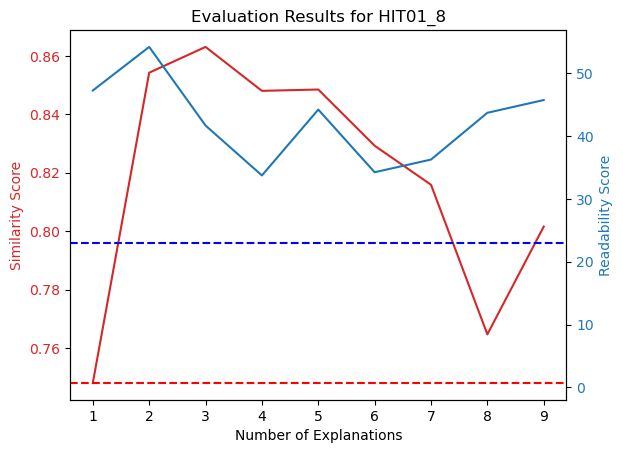

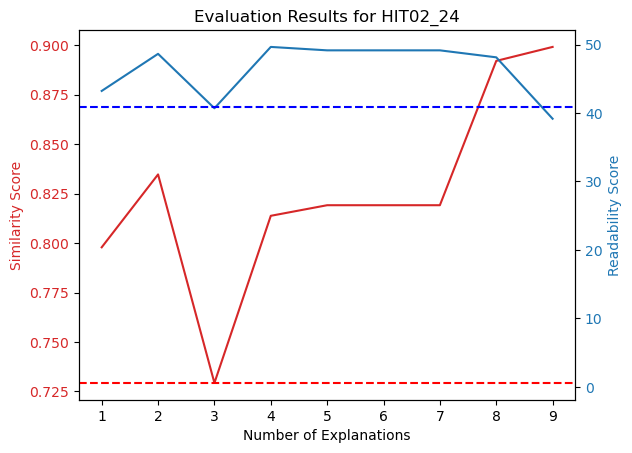

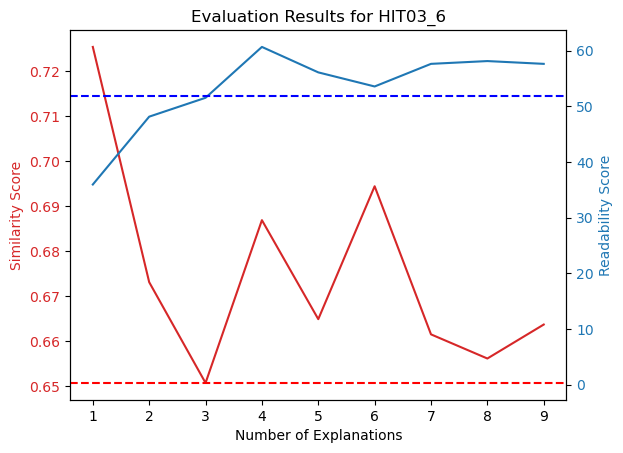

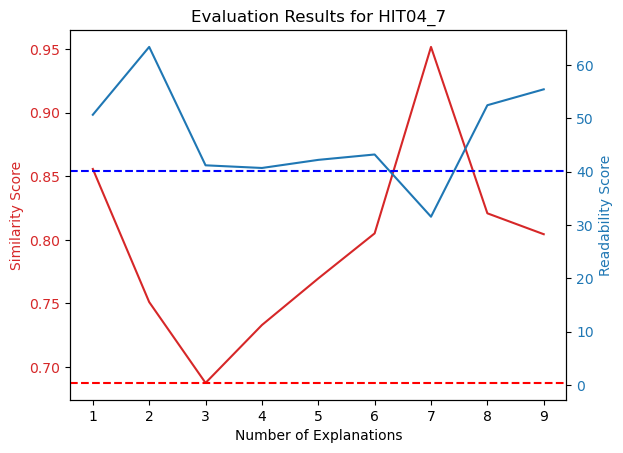

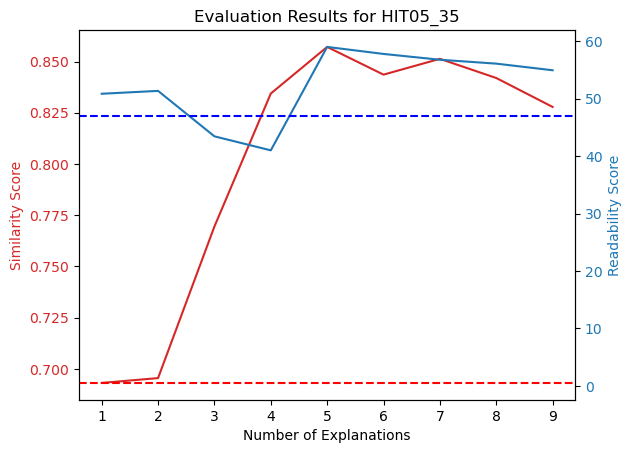

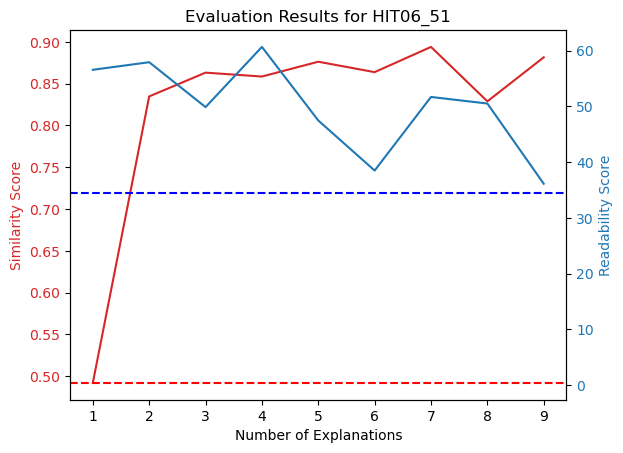

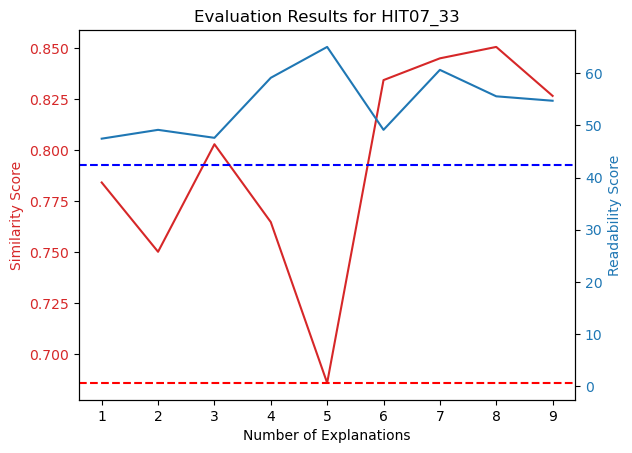

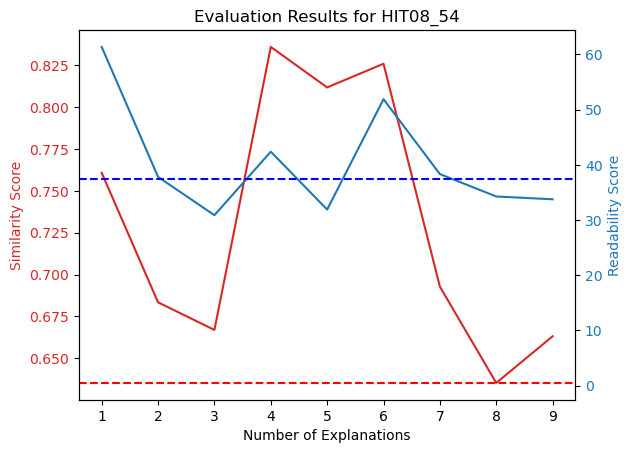

In [101]:
for method, results in evaluation_results_small.items():
    plot_evaluation_results(method, results)

We can observe that in this case the results are a lot more variable. This is to be expected as we add a lot of new information each time relative to the input length.
The overall trend of the similarity score is almost a 50:50 splits between the methods: While half of them seem to improve with more explanations, many also have reduced similarity scores. However, when we compare to the more coarser evaluation results for 10 explanation increments we can see that this does not necessarily reflect the overall trend. We can also see when the model heavily relies on one new explanation. For example for the method HIT03_6 at 3 or 5 explanations the model seems to heavily rely on the new explanation which seems to be more dissimilar to the ground truth and reduces the similarity score.
Overall, the similarity is pretty high which to some extend has to be ascribed to the fact that the model tends to use similar sentence structures and words.
The readability score shows stronger changes. This is in line with looking at the provided results as the exact explanations can also change a lot.